# Apply NORDic to the ``toy_star_1`` synthetic dataset

In [1]:
import NORDic
from IPython.display import Image
import pandas as pd

dataset_name = "toy_star_1"
pert_genes = ["gene%d" % i for i in range(1,11)]

file_folder=f"{dataset_name}/"
seed_number=123456

In this case, we directly have access to binarized (Boolean) trajectories from an initial state to a single steady state (plus intermediary states, that will be ignored) for several synthetic KO experiments.

Let's convert this into a NORDic-compatible format.


## 0. Retrieve the data

In [2]:
import os
from subprocess import Popen

proc = Popen(f"mkdir -p {file_folder}".split(" "))
proc.wait()

data_url="https://raw.githubusercontent.com/gt-bioss/benchmark-dynamical-models/main/"
data_url+=f"from-boolean-networks/{dataset_name}/ground-truth/"

exp_list = ["wt-boolean-trajectories.csv"]+[
    "%sKO-boolean-trajectories.csv" % g
    for g in pert_genes
]

for exp in exp_list:
    proc = Popen(f"wget -O {file_folder}/{exp} -q {data_url}/{exp}".split(" "))
    proc.wait()
    df = pd.read_csv(f"{file_folder}/{exp}", sep=",", index_col=0)
    print(exp)
    print(df.head())
    gene_lst = list(df.columns)

wt-boolean-trajectories.csv
                   tf  gene1  gene2  gene3  gene4  gene5  gene6  gene7  gene8  \
init                1      0      0      0      0      0      0      0      0   
init_to_steady1_1   1      0      1      0      0      0      0      0      0   
init_to_steady1_2   1      0      1      0      0      0      0      0      1   
init_to_steady1_3   1      0      1      1      0      0      0      0      1   
init_to_steady1_4   1      0      1      1      1      0      0      0      1   

                   gene9  gene10  
init                   0       0  
init_to_steady1_1      0       0  
init_to_steady1_2      0       0  
init_to_steady1_3      0       0  
init_to_steady1_4      0       0  
gene1KO-boolean-trajectories.csv
                   tf  gene1  gene2  gene3  gene4  gene5  gene6  gene7  gene8  \
init                1      0      0      0      0      0      0      0      0   
init_to_steady1_1   1      0      1      0      0      0      0      0      0   

## 1. Prior Knowledge Network

The dataset is synthetic, so there is no prior on the structure of the network. We then build a complete graph (to prevent the resort to the STRING database which will be otherwise useless).

In [3]:
NETWORK_fname = f"{file_folder}/complete_ppi.tsv"

all_pairs = [(g, gp) for ig, g in enumerate(gene_lst) for gp in gene_lst[(ig+1):]] ## all unique distinct pairs
PPI = pd.DataFrame([
    [g, gp, 1, 0, 0.5] ## build undirected edges with score=0.5 and positive
    for g, gp in all_pairs
], columns=["preferredName_A", "preferredName_B", "sign", "directed", "score"], index=range(len(all_pairs)))
PPI.to_csv(NETWORK_fname, sep="\t", index=None)

n=len(gene_lst)
print("%d edges in total (expected %d)" % (len(all_pairs), n*(n-1)/2))
PPI.head()

55 edges in total (expected 55)


,preferredName_A,preferredName_B,sign,directed,score
0,tf,gene1,1,0,0.5
1,tf,gene2,1,0,0.5
2,tf,gene3,1,0,0.5
3,tf,gene4,1,0,0.5
4,tf,gene5,1,0,0.5


## 2. Experimental file

We convert the Boolean trajectories that we retrieved into a format compatible with NORDic. For each retrieved experimental file (corresponding to a single (non)perturbation experiment):

- There is the Boolean state of the initial condition named ``init``
- We ignore intermediary states named ``init_to_steady1_*``
- There is the final steady state named ``steady1``

In [4]:
EXPERIMENTS_fname = f"{file_folder}/experiments.csv"
experiments = pd.DataFrame([], index=gene_lst+["annotation", "perturbed", "perturbation", "cell_line", "sigid"])
cell="".join(dataset_name.split("_")) ## no "_"

for ie, exp in enumerate(exp_list):
    df = pd.read_csv(f"{file_folder}/{exp}", sep=",", index_col=0)
    if ("wt-" in exp):
        experiments[f"initial_{cell}"] = df.loc["init"][gene_lst].values.flatten().tolist()+["1","None","None",cell,f"{exp}:init"]
        continue
    pert_gene = exp.split("KO")[0]
    pert_dir = "KD"
    exp_name = f"{pert_gene}_KD_"+cell
    steady_name = "steady"+("1" if ("steady1" in df.index) else "")
    experiments[exp_name] = df.loc[steady_name][gene_lst].values.flatten().tolist()+["2",pert_gene,pert_dir,cell,f"{exp}:steady"]
experiments.to_csv(EXPERIMENTS_fname, sep=",")

experiments.T.head()

,tf,gene1,gene2,gene3,gene4,gene5,gene6,gene7,gene8,gene9,gene10,annotation,perturbed,perturbation,cell_line,sigid
initial_toystar1,1,0,0,0,0,0,0,0,0,0,0,1,None,None,toystar1,wt-boolean-trajectories.csv:init
gene1_KD_toystar1,1,0,1,1,1,1,1,1,1,1,1,2,gene1,KD,toystar1,gene1KO-boolean-trajectories.csv:steady
gene2_KD_toystar1,1,1,0,1,1,1,1,1,1,1,1,2,gene2,KD,toystar1,gene2KO-boolean-trajectories.csv:steady
gene3_KD_toystar1,1,1,1,0,1,1,1,1,1,1,1,2,gene3,KD,toystar1,gene3KO-boolean-trajectories.csv:steady
gene4_KD_toystar1,1,1,1,1,0,1,1,1,1,1,1,2,gene4,KD,toystar1,gene4KO-boolean-trajectories.csv:steady


## 3. Parameters

Not needed, since both the PKN and the experiments are available from the start.

In [5]:
from multiprocessing import cpu_count
njobs=1

## Random
taxon_id=1111
disease_cids=["Unknown"] 
cell_lines=[cell]
path_to_genes=None

DisGeNET_credentials = ""
STRING_credentials = ""
LINCS_credentials = ""
DISGENET_args = {"credentials": DisGeNET_credentials, "disease_cids": disease_cids}
STRING_args = {"credentials": STRING_credentials, "score": 0}
EDGE_args = {"tau": None, "filter": False, "connected": True}
accept_nonRNA=True
preserve_network_sign=True
LINCS_args = {"path_to_lincs": "", 
              "credentials": LINCS_credentials,
              "cell_lines": cell_lines, "thres_iscale": None}
SIG_args = {"bin_thres": 0.5}
force_experiments=False
DESIRABILITY = {"DS": 3, "CL": 3, "Centr": 3, "GT": 1}

## Identification parameters
BONESIS_args = {"limit": 500, "exact": False, "max_maxclause": 1}

## 4. Network identification

In [6]:
from NORDic.NORDic_NI.functions import network_identification

solution = NORDic.NORDic_NI.functions.network_identification(
    file_folder, taxon_id, path_to_genes=path_to_genes, disgenet_args=DISGENET_args, 
    string_args=STRING_args, lincs_args=LINCS_args, edge_args=EDGE_args, sig_args=SIG_args,
    bonesis_args=BONESIS_args, weights=DESIRABILITY, experiments_fname=EXPERIMENTS_fname,
    seed=seed_number, network_fname=NETWORK_fname, njobs=njobs, force_experiments=force_experiments, 
    accept_nonRNA=accept_nonRNA, preserve_network_sign=preserve_network_sign)

--- DATA IMPORT ---
1. Import gene set from DisGeNET... ... 11 genes imported.
2. Import network from toy_star_1//complete_ppi.tsv... ... 55 edges in model (including 0 directed edges) with a total of 11 non-isolated genes
3. Import experiments from toy_star_1//experiments.csv... 
	1 cell lines are considered (['toystar1'])
... 11 genes in 11 profiles (11 experiments)

--- CONSTRAINT BUILDING ---
1. Filtering out edges by minimum set of edges with highest score which preserve connectivity... ... 55 unique edges involving genes both in experiments (11 genes in total)
... score_STRING 0.000000	11 genes (non isolated in PPI)	110 edges in PPI
2. Build topological constraints from filtered edges using gene expression data...  ...... 0 negative, 110 positive undirected interactions (110 edges in total), 11 non isolated genes in experiments
3. Build dynamical constraints by binarization of experimental profiles...  ...... 10 experiments on 1 cell lines and 11/11 genes (Frobenius norm signatur

  0%|                                                                                                | 0/1 [00:00<?, ?it/s]

Grounding...done in 0.0s
Found 500 solutions in 7.2s (first in 0.0s; rate 0.0s)

100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.19s/it]

--- SELECTION OF OPTIMAL MODEL ---
A. Select an optimal model based on a topological criteria...  ...

500 solutions (500 unique solutions)
... 500 solutions (7/12 constant genes in average)
<MODEL VISUALIZATION> Minimal solution: 0 edges
<MODEL VISUALIZATION> Maximal solution: 7 edges
          1       2       3         4       5         6         7         8    \
GTP  0.829375  0.8524  0.8524  0.868908  0.8524  0.868908  0.797309  0.829375   

          9         10        11        12      13      14        15   \
GTP  0.880757  0.829375  0.829375  0.829375  0.8524  0.8524  0.829375   

          16        17        18        19        20        21        22   \
GTP  0.868908  0.797309  0.829375  0.829375  0.829375  0.880757  0.868908   

        23        24        25      26        27      28        29      30   \
GTP  0.8524  0.797309  0.829375  0.8524  0.829375  0.8524  0.868908  0.8524   

        31      32        33        34      35        36        37        38   \
GTP  0.8524  0.8524  0.868908  0.797309  0.8524  0.829375  0.829375  0.868908   

          39      40        4

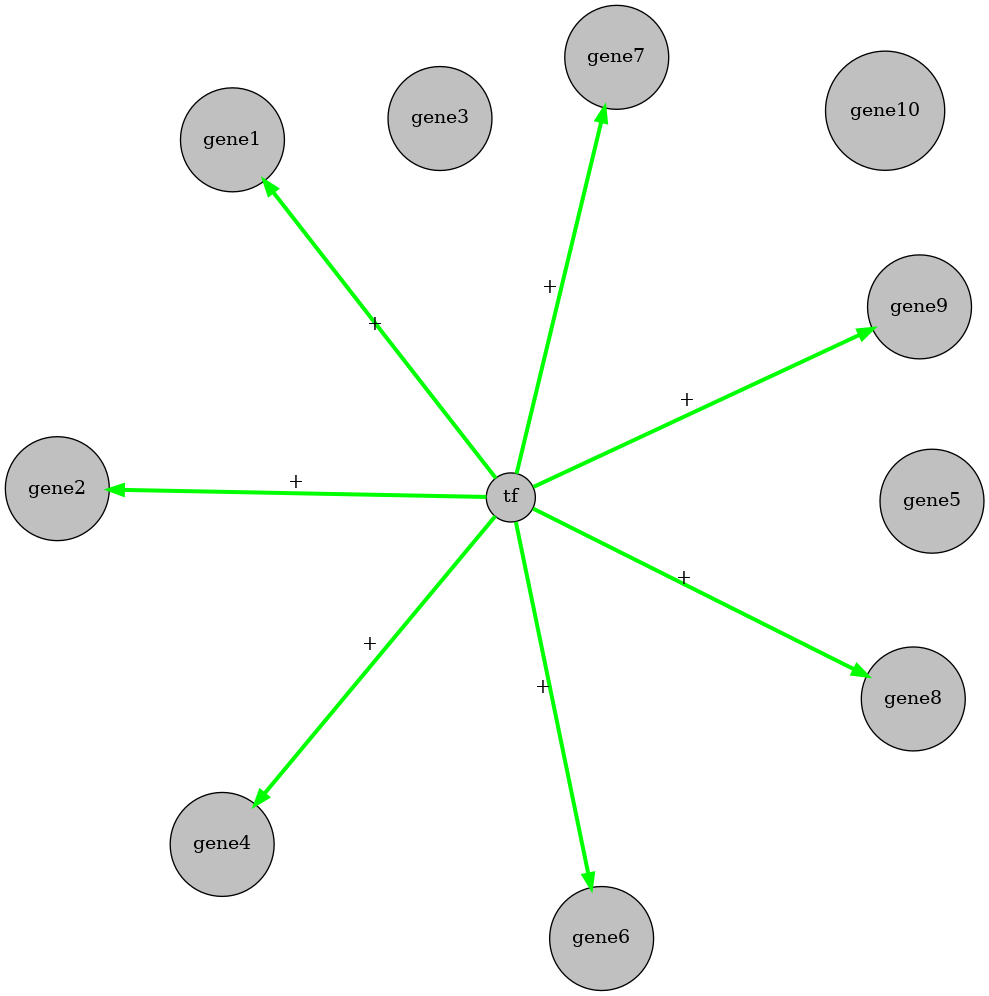

In [7]:
from IPython.display import Image
Image(filename=f'{file_folder}/inferred_max_criterion_solution.png') 

In [8]:
pd.read_csv(f"{file_folder}/GPT.csv", index_col=0).T.sort_values(by="GTP", ascending=False)

,GTP
320,0.889284
180,0.889284
121,0.889284
291,0.889284
288,0.880757
...,...
401,0.752907
399,0.752907
339,0.752907
378,0.752907


## 5. Ground truth network

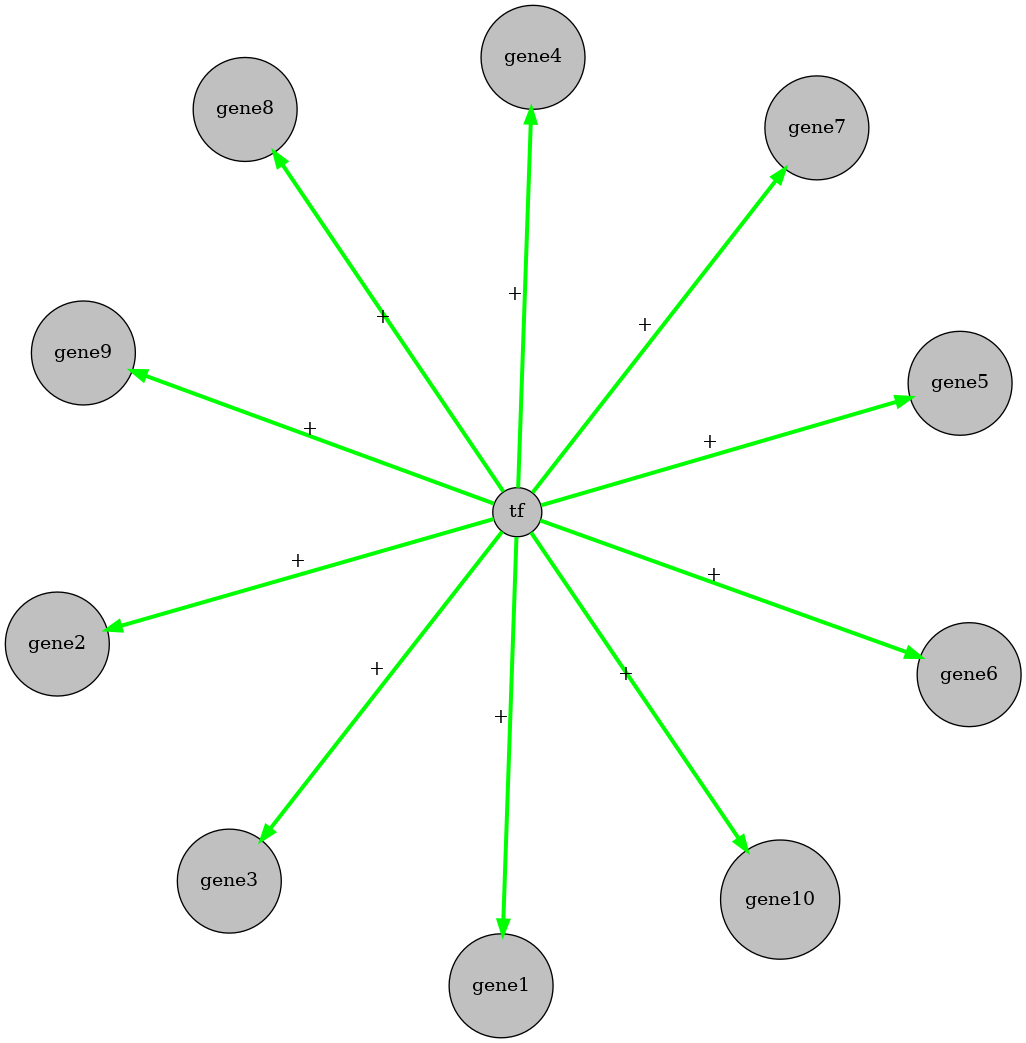

In [9]:
network_fname="boolean-network.bnet"
proc = Popen(f"wget -O {file_folder}/{network_fname} -q {data_url}/{network_fname}".split(" "))
proc.wait()

from NORDic.UTILS.utils_grn import solution2influences
from NORDic.UTILS.utils_plot import influences2graph

with open(f"{file_folder}/{network_fname}", "r") as f:
    ground_truth = pd.DataFrame({
        "Solution": dict([["_".join(g.split("-")) for g in x.split(", ")] for x in f.read().split("\n") if (len(x)>0)])
    })
influences_ground_truth = solution2influences(ground_truth["Solution"])
influences2graph(influences_ground_truth, file_folder+"ground_truth", optional=False, compile2png=True, engine=["sfdp","dot"][0])
from IPython.display import Image
Image(filename=file_folder+'ground_truth.png') 